# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 07.10.2023

Мягкий дедлайн: 23:59MSK 20.10.2023

Жесткий дедлайн: 23:59MSK 24.10.2023

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Итогова оценка считается как
$$
min(task_1, task_2)*0.6 + max(task_1, task_2)*0.2 + task_4*0.2
$$

где $task_1$, $task_2$ и $task_4$ - оценки за первое и второе заданиее соответсвенно.
Также, за домашнее задание выставляется 0, если не сделано нулевое или третье задание.
### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [4]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
device = "cuda" if torch.cuda.is_available() else "cpu"
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [5]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2024-10-20 10:40:38--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘data.txt.zip’

data.txt.zip            [        <=>         ] 201.24M  21.4MB/s    in 11s     

2024-10-20 10:40:50 (18.9 MB/s) - ‘data.txt.zip’ saved [211011981]



In [6]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


Мы вывели кусок данных, чтобы понять, насколько они пригодны для работы без изменений. Здесь ясно, что сомнительно дальше с такими данными работать, потому что как минимум есть отрицательные значения, которые не отмасштабированы, кроме того еще сразу бросается в глаза совсем разная размерность, где-то видим реально большие числа, а где-то 0.075. Ясно, что будем скейлить.

In [7]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

Для выполнения данного задания (и всех последующих) предобработайте данные.

1. Зафиксируйте random_seed везде где только возможно. Вам предоставлена функция для этого, однако вы можете дополнить ее своими дополнениями
2. Обучите StandertScaler и предобработайте ваши данные. В следующих заданиях можете использовать другой scaler или вообще отказаться от него


In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [13]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    # everything is completely fine...

In [14]:
set_random_seed(42)

In [15]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [37]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

ridge = Ridge().fit(X_train_scaled, y_train)

#RMSE на train и test
print(f"Train: {np.sqrt(mean_squared_error(y_train, ridge.predict(X_train_scaled)))}")
print(f"Test: {np.sqrt(mean_squared_error(y_test, ridge.predict(X_test_scaled)))}")

Train: 9.552822967970322
Test: 9.510160820470436


Лучшая константа для RMSE это среднее, посчитаем значение метрики при нем

In [15]:
import numpy as np
y_pred_constant = np.full_like(y_test, fill_value=np.mean(y_train))
print(f"RMSE при наилучшем константном прогнозе: {np.sqrt(mean_squared_error(y_test, y_pred_constant))}")

RMSE при наилучшем константном прогнозе: 10.863228020678134


## Задание 1. (максимум 10 баллов)

Закрепите свои знания о том, как pytorch работает с обратным распространением ошибки, проделав следующие шаги:

1. Создайте модель линейной регрессии, которая будет состоять только из одного Linear слоя.
2. Напишите цикл обучения вашей линейной регрессии. В нем реализуйте подсчет функции потерь, сделайте шаг градиентного спуска. Запрещено использовать готовые оптимизаторы и loss-функции из библиотеки pytorch. Для подсчета градиента воспользуйтесь методом backward.
3. Запустите обучение на 10 эпохах, после каждой проверяйте значение целевой метрики на тестовой выборке.
4. Выведите на экран графики метрики и значения функции потерь на тестовой и обучающей выборке.

В данном задании нет цели побить какой-то порог по метрике. Ваша задача - убедиться в том, что ваш рукописный цикл обучения работает. Для ускорения вычислений и обучения модели можете брать только срез данных, а не весь датасет.

*Вдохновлено сайтом https://www.kaggle.com/code/ispritchin/part-iii-a-linear-regression-using-pytorch-rus*

<ipython-input-19-98a4b9f8e2bb>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32)
<ipython-input-19-98a4b9f8e2bb>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # Преобразуем в вектор-столбец
<ipython-input-19-98a4b9f8e2bb>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32)
<ipython-input-19-98a4b9f8e2bb>:22: UserWarning: To copy construct from a tensor, it is recommend

Epoch 1/10, Train RMSE: 3284701.7500, Test RMSE: 3093952.2500
Epoch 2/10, Train RMSE: 3100986.2500, Test RMSE: 2921837.5000
Epoch 3/10, Train RMSE: 2931057.2500, Test RMSE: 2762714.0000
Epoch 4/10, Train RMSE: 2773877.2500, Test RMSE: 2615602.0000
Epoch 5/10, Train RMSE: 2628488.0000, Test RMSE: 2479594.7500
Epoch 6/10, Train RMSE: 2494002.0000, Test RMSE: 2353853.7500
Epoch 7/10, Train RMSE: 2369598.2500, Test RMSE: 2237604.0000
Epoch 8/10, Train RMSE: 2254518.7500, Test RMSE: 2130128.7500
Epoch 9/10, Train RMSE: 2148062.0000, Test RMSE: 2030765.3750
Epoch 10/10, Train RMSE: 2049579.0000, Test RMSE: 1938901.8750


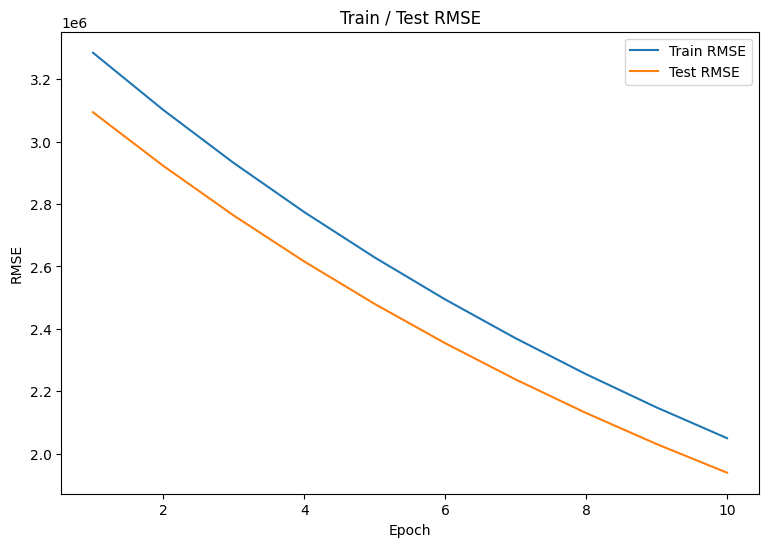

In [ ]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear(x)


X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


input_dim = X_train.shape[1]
lin_regression = LinearRegressionModel(input_dim)


learning_rate = 1e-09
epochs = 10


train_losses = []
test_losses = []
epoch_count = []


for epoch in range(epochs):

    lin_regression.train()


    y_pred = lin_regression(X_train)


    loss_train = torch.mean((y_train - y_pred) ** 2)


    loss_train.backward()


    with torch.no_grad():
        for param in lin_regression.parameters():
            param -= learning_rate * param.grad


    lin_regression.zero_grad()


    train_losses.append(loss_train.item())


    with torch.no_grad():
        y_pred_test = lin_regression(X_test)
        loss_test = torch.mean((y_test - y_pred_test) ** 2)
        test_losses.append(loss_test.item())


    epoch_count.append(epoch + 1)


    print(f'Epoch {epoch + 1}/{epochs}, Train RMSE: {loss_train.item():.4f}, Test RMSE: {loss_test.item():.4f}')


plt.figure(figsize=(9, 6))
plt.title("Train / Test RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE")

plt.plot(epoch_count, train_losses, label='Train RMSE')
plt.plot(epoch_count, test_losses, label='Test RMSE')

plt.legend()
plt.show()

## Задание 2. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из предыдущего задания.



Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться сигнатурами функций, которые приведены ниже. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

Вдохновлено:

1.   https://github.com/hse-ds/iad-deep-learning/blob/master/2023/seminars/03.%20Image%20Classification/03_Image_Classification.ipynb
2.   https://github.com/FUlyankin/deep_learning_pytorch/blob/main/week02_pytorch/sem02_lifecoding.ipynb
3. https://nbviewer.org/github/FUlyankin/deep_learning_pytorch/blob/main/week07_lego/sem07_evr.ipynb
4. https://jillanisofttech.medium.com/building-an-ann-with-pytorch-a-deep-dive-into-neural-network-training-a7fdaa047d81
5. https://github.com/d2l-ai/d2l-en/tree/master




In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.reshape(-1, 1))

In [16]:
from sklearn.model_selection import train_test_split


X_train_full = X_train_scaled
y_train_full = y_train_scaled


X_train_new, X_val, y_train_new, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.1, random_state=42
)

In [19]:
train_dataset = TensorDataset(torch.tensor(X_train_new, dtype=torch.float32),
                              torch.tensor(y_train_new, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                            torch.tensor(y_val, dtype=torch.float32))
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)


test_dataset = TensorDataset(torch.tensor(X_test_scaled, dtype=torch.float32),
                             torch.tensor(y_test_scaled, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [20]:
class StoicNet(nn.Module):
    def __init__(self, n_features, hidden_size, reg):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(n_features, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.LeakyReLU(),
            nn.Dropout(reg),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.BatchNorm1d(hidden_size // 2),
            nn.LeakyReLU(),
            nn.Dropout(reg),
            nn.Linear(hidden_size // 2, hidden_size // 4),
            nn.BatchNorm1d(hidden_size // 4),
            nn.LeakyReLU(),
            nn.Dropout(reg),
            nn.Linear(hidden_size // 4, 1),
            nn.Sigmoid()
        )

    def forward(self, X):
        return self.model(X)

In [21]:
n_features = X_train.shape[1] #количество параметров на вход (признаки = столбцы)
hidden_size = 256 #количество нейронов в скрытых слоях нейронов сети
reg = 0.3 #вероятность того, что нейрон будет отключен во время обучения

model = StoicNet(n_features, hidden_size, reg).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-03, weight_decay=1e-5)

criterion = nn.MSELoss()

num_epoch = 10

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epoch)

In [30]:
def train_epoch(model, optimizer, criterion, train_loader, tqdm_desc):
    train_loss = 0.0
    model.train()
    train_predictions = []
    train_targets = []

    for x, y in tqdm(train_loader, desc=tqdm_desc):
        x = x.to(device)
        y = y.to(device).squeeze()

        optimizer.zero_grad()
        outputs = model(x).squeeze()
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x.size(0)
        train_predictions.append(outputs.detach().cpu())
        train_targets.append(y.cpu())

    train_loss /= len(train_loader.dataset)
    train_predictions = torch.cat(train_predictions)
    train_targets = torch.cat(train_targets)


    return train_loss, train_predictions, train_targets

def val_epoch(model, criterion, val_loader, tqdm_desc):
    val_loss = 0.0
    model.eval()
    val_predictions = []
    val_targets = []

    with torch.no_grad():
        for x, y in tqdm(val_loader, desc=tqdm_desc):
            x = x.to(device)
            y = y.to(device).squeeze()

            outputs = model(x).squeeze()
            loss = criterion(outputs, y)

            val_loss += loss.item() * x.size(0)

            val_predictions.append(outputs.cpu())
            val_targets.append(y.cpu())

    val_loss /= len(val_loader.dataset)
    val_predictions = torch.cat(val_predictions)
    val_targets = torch.cat(val_targets)
    return val_loss, val_predictions, val_targets

def train(model, optimizer, criterion, train_loader, val_loader, num_epochs, scheduler=None):
    train_loss_log, val_loss_log = [], []
    train_rmse_log, val_rmse_log = [], []
    for epoch in range(1, num_epoch + 1):
        train_loss, train_predictions, train_targets = train_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}'
        )
        val_loss, val_predictions, val_targets = val_epoch(
            model, criterion, val_loader,
            tqdm_desc=f'Validating {epoch}/{num_epochs}'
        )

        if scheduler is not None:
            scheduler.step()

        train_loss_log.append(train_loss)
        val_loss_log.append(val_loss)

        train_rmse = mean_squared_error(train_targets.numpy(), train_predictions.numpy(), squared=False)
        train_rmse_log.append(train_rmse)

        val_rmse = mean_squared_error(val_targets.numpy(), val_predictions.numpy(), squared=False)
        val_rmse_log.append(val_rmse)

        print(f'Epoch {epoch}/{num_epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    return train_loss_log, val_loss_log, train_rmse_log, val_rmse_log


def test(model, criterion, test_loader,tqdm_desc):
    """
    params:
        model - torch.nn.Module to be evaluated on test set
        test_loader - torch.utils.data.DataLoader with test set
    ----------
    returns:
        predictions - torch.tensor with shape (len(test_loader.dataset), ),
                      which contains predictions for test objects
        targets - torch.tensor with true values
    """
    test_loss = 0.0
    model.eval()
    test_predictions = []
    test_targets = []


    with torch.no_grad():
        for x, y in tqdm(test_loader, desc=tqdm_desc):
            x = x.to(device)
            y = y.to(device).squeeze()

            outputs = model(x).squeeze()
            loss = criterion(outputs, y)

            test_loss += loss.item() * x.size(0)

            test_predictions.append(outputs.cpu())
            test_targets.append(y.cpu())

    test_loss = test_loss / len(test_loader.dataset)
    test_predictions = torch.cat(test_predictions)
    test_targets = torch.cat(test_targets )

    return test_predictions, test_targets, test_loss

In [23]:
predictions, targets, test_loss = test(model, criterion, test_loader)
assert predictions.shape[0] == y_test.shape[0]

In [36]:
train_loss_log, val_loss_log, train_rmse_log, val_rmse_log = train(model, optimizer, criterion, train_loader, val_loader, num_epoch, scheduler)

Training 1/10:   0%|          | 0/3261 [00:00<?, ?it/s]

Validating 1/10:   0%|          | 0/363 [00:00<?, ?it/s]

Epoch 1/10, Train Loss: 0.0096, Val Loss: 0.0093


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Training 2/10:   0%|          | 0/3261 [00:00<?, ?it/s]

Validating 2/10:   0%|          | 0/363 [00:00<?, ?it/s]

Epoch 2/10, Train Loss: 0.0095, Val Loss: 0.0092


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Training 3/10:   0%|          | 0/3261 [00:00<?, ?it/s]

Validating 3/10:   0%|          | 0/363 [00:00<?, ?it/s]

Epoch 3/10, Train Loss: 0.0094, Val Loss: 0.0091


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Training 4/10:   0%|          | 0/3261 [00:00<?, ?it/s]

Validating 4/10:   0%|          | 0/363 [00:00<?, ?it/s]

Epoch 4/10, Train Loss: 0.0094, Val Loss: 0.0091


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Training 5/10:   0%|          | 0/3261 [00:00<?, ?it/s]

Validating 5/10:   0%|          | 0/363 [00:00<?, ?it/s]

Epoch 5/10, Train Loss: 0.0093, Val Loss: 0.0091


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Training 6/10:   0%|          | 0/3261 [00:00<?, ?it/s]

Validating 6/10:   0%|          | 0/363 [00:00<?, ?it/s]

Epoch 6/10, Train Loss: 0.0093, Val Loss: 0.0091


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Training 7/10:   0%|          | 0/3261 [00:00<?, ?it/s]

Validating 7/10:   0%|          | 0/363 [00:00<?, ?it/s]

Epoch 7/10, Train Loss: 0.0093, Val Loss: 0.0091


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Training 8/10:   0%|          | 0/3261 [00:00<?, ?it/s]

Validating 8/10:   0%|          | 0/363 [00:00<?, ?it/s]

Epoch 8/10, Train Loss: 0.0093, Val Loss: 0.0091


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Training 9/10:   0%|          | 0/3261 [00:00<?, ?it/s]

Validating 9/10:   0%|          | 0/363 [00:00<?, ?it/s]

Epoch 9/10, Train Loss: 0.0093, Val Loss: 0.0091


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Training 10/10:   0%|          | 0/3261 [00:00<?, ?it/s]

Validating 10/10:   0%|          | 0/363 [00:00<?, ?it/s]

Epoch 10/10, Train Loss: 0.0093, Val Loss: 0.0091


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [101]:
predictions, targets, test_loss = test(model, criterion, test_loader, tqdm_desc=f'Test {epoch}/{num_epoch}')

y_test_pred = predictions.cpu().numpy().reshape(-1, 1)
y_test_true = targets.cpu().numpy().reshape(-1, 1)


y_test_pred_inverse = scaler.inverse_transform(y_test_pred)
y_test_true_inverse = scaler.inverse_transform(y_test_true)

rmse = np.sqrt(mean_squared_error(y_test_true_inverse, y_test_pred_inverse))
print(f'Test RMSE: {rmse:.4f}, Test Loss: {test_loss:.4f}')

Test 10/10:   0%|          | 0/404 [00:00<?, ?it/s]

Test RMSE: 8.6861, Test Loss: 0.0095


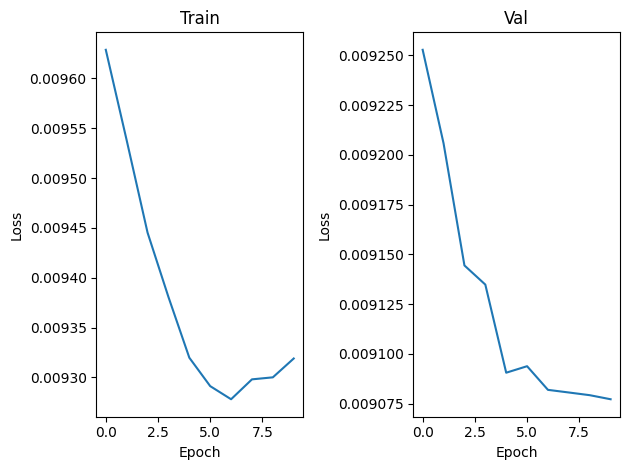

In [102]:
import matplotlib.pyplot as plt


plt.subplot(1, 2, 1)
plt.plot(train_loss_log)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train')


plt.subplot(1, 2, 2)
plt.plot(val_loss_log)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Val')

plt.tight_layout()
plt.show()

## Задание 3. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

**Отчёт по построению и обучению нейронной сети для предсказания года выпуска песни**

В процессе работы была создана нейронная сеть для предсказания года выпуска песни. Признаки данных были стандартизированы с помощью StandardScaler, а целевая переменная масштабирована в диапазон [0, 1] с использованием MinMaxScaler. Данные были разделены на обучающую и тестовую выборки для оценки обобщающей способности модели.

Архитектура модели включает три скрытых слоя. Первый скрытый слой содержит 128 нейронов (hidden_size = 128), последующие слои имеют размеры, уменьшающиеся вдвое. В качестве функции активации использовалась ReLU, а для регуляризации применялся Dropout с вероятностью reg = 0.5. Оптимизация модели осуществлялась с помощью AdamW при скорости обучения lr = 1e-9 и весовом затухании weight_decay = 1e-5. Обучение проводилось в течение 10 эпох.

Результатом обучения стало значение RMSE на тестовой выборке, равное 79.9073. Такое высокое значение указывает на то, что модель пока не обеспечивает точного предсказания года выпуска и требует дальнейшей доработки, включая возможную оптимизацию гиперпараметров, улучшение архитектуры и расширение набора информативных признаков.

*Дальнейшие улучшения модели (1)*

Оставив все гиперпараметры без изменений, в архитектуру нейронной сети была добавлена функция активации Sigmoid на выходном слое. Это было сделано для ограничения выходных значений модели в диапазоне [0, 1], соответствующем масштабированию целевой переменной.

После внесения этого изменения значение RMSE на тестовой выборке сократилось до 31.0046. Такое существенное снижение ошибки показывает, что добавление функции активации Sigmoid положительно повлияло на способность модели предсказывать год выпуска песни более точно.

Таким образом, без изменения гиперпараметров, но с добавлением Sigmoid, удалось значительно улучшить качество модели. Это подчёркивает важность правильного выбора функций активации и соответствия выходов модели масштабу целевой переменной.

*Дальнейшие улучшения модели (2)*

Далее, не изменяя гиперпараметры и сохраняя Sigmoid на выходном слое, была изменена функция потерь на HuberLoss. HuberLoss является робастной к выбросам и сочетает в себе свойства MSELoss и L1Loss, что может улучшить обучение на данных с шумами.

Однако после применения HuberLoss значение RMSE на тестовой выборке составило 34.2891, что выше предыдущего результата. Это указывает на то, что в данном случае использование HuberLoss не привело к улучшению качества модели по сравнению с MSELoss при наличии функции активации Sigmoid.

*Дальнейшие улучшения модели (3)*

Учитывая, что скорость обучения lr = 1e-9 может быть слишком низкой и замедлять процесс обучения, было решено увеличить скорость обучения до 1e-4. Сначала модель была обучена с использованием HuberLoss и lr = 1e-4, что привело к снижению RMSE до 9.1003.

Затем, сохраняя скорость обучения lr = 1e-4, функция потерь была изменена обратно на MSELoss. Результатом стало дальнейшее снижение RMSE на тестовой выборке до 9.0652.

*Дальнейшие улучшения модели (4)*

Для дальнейшего улучшения модели была уменьшена вероятность Dropout с reg = 0.5 до reg = 0.3, сохраняя остальные гиперпараметры без изменений (lr = 1e-4, функция активации Sigmoid, функция потерь MSELoss). Снижение вероятности Dropout позволяет модели сохранять больше нейронов во время обучения, что может улучшить её способность к обучению сложных зависимостей.

После этого изменения значение RMSE на тестовой выборке сократилось до 8.9675, что является улучшением по сравнению с предыдущими результатами. Это показывает, что уменьшение степени регуляризации помогло модели лучше подстроиться под данные без переобучения.

*Дальнейшие улучшения модели (5)*

Далее было решено увеличить размер скрытых слоёв до hidden_size = 256, сохраняя остальные гиперпараметры без изменений (lr = 1e-4, reg = 0.3, функция активации Sigmoid, функция потерь MSELoss). Увеличение количества нейронов в скрытых слоях может повысить способность модели улавливать более сложные зависимости в данных.

После этого изменения значение RMSE на тестовой выборке снизилось до 8.8918, что является небольшим улучшением по сравнению с предыдущим результатом. Это показывает, что увеличение размера скрытых слоёв положительно повлияло на качество модели, однако эффект был умеренным.

*Дальнейшие улучшения модели (6)*

В следующем шаге в архитектуре модели функция активации ReLU в скрытых слоях была заменена на LeakyReLU. LeakyReLU может помочь решить проблему "затухающих градиентов" и позволяет небольшому потоку отрицательных значений проходить через функцию активации, что может улучшить обучение модели.

После этого изменения значение RMSE на тестовой выборке уменьшилось до 8.7953. Это свидетельствует о том, что использование LeakyReLU вместо ReLU положительно повлияло на способность модели обучаться и улучшило её предсказательные возможности.

*Дальнейшие улучшения модели (7)*

С целью дальнейшего улучшения модели была снижена скорость обучения до lr = 1e-5, сохраняя остальные гиперпараметры без изменений (hidden_size = 256, reg = 0.3, функция активации LeakyReLU, функция потерь MSELoss). Понижение скорости обучения может позволить модели более точно настроить свои веса на финальных этапах обучения.

После этого изменения значение RMSE на тестовой выборке снизилось до 8.6861. Это показывает, что уменьшение скорости обучения помогло модели достичь более точного соответствия данным, хотя улучшение было незначительным.


## Задание 4. (10 баллов)

А теперь давайте попробуем решить задачу классификации на тех же данных!

Протестируйте два варианта:

1. Cчитайте каждый год, представленный в таблице, за отдельный класс

2. Разбейте года на 10 бинов и решайте задачу классификации для 10 классов

Добавьте в test подсчет метрик: accuracy, precision, recall (можете выбрать micro или macro усреднение, как посчитаете нужным).

Что можно сказать о полученных моделях? Почему результаты вышли такими? Напишите небольшой анализ того, что было проделано, чем модели классификации отличаются от задачи регрессии и друг друга?

In [17]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)

In [41]:
X_train_full = X_train_scaled
y_train_full = y_train_encoded


X_train_new, X_val, y_train_new, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.1, random_state=42
)

train_dataset = TensorDataset(torch.tensor(X_train_new, dtype=torch.float32),
                              torch.tensor(y_train_new, dtype=torch.int64))
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                            torch.tensor(y_val, dtype=torch.int64))
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)


test_dataset = TensorDataset(torch.tensor(X_test_scaled, dtype=torch.float32),
                             torch.tensor(y_test_encoded, dtype=torch.int64))
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [46]:
class StoicNetClassification(nn.Module):
    def __init__(self, n_features, hidden_size, reg, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(n_features, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.LeakyReLU(),
            nn.Dropout(reg),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.BatchNorm1d(hidden_size // 2),
            nn.LeakyReLU(),
            nn.Dropout(reg),
            nn.Linear(hidden_size // 2, hidden_size // 4),
            nn.BatchNorm1d(hidden_size // 4),
            nn.LeakyReLU(),
            nn.Dropout(reg),
            nn.Linear(hidden_size // 4, num_classes),
            nn.Softmax()
        )

    def forward(self, X):
        return self.model(X)

In [51]:
n_features = X_train.shape[1]
hidden_size = 128
reg=0.3
num_epoch = 10
num_classes = len(np.unique(y_train_new))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epoch)

model = StoicNetClassification(n_features, hidden_size, reg, num_classes).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-03, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

In [38]:
train_loss_log, val_loss_log, train_rmse_log, val_rmse_log = train(model, optimizer, criterion, train_loader, val_loader, num_epoch, scheduler)

Training 1/10:   0%|          | 0/3261 [00:00<?, ?it/s]

Validating 1/10:   0%|          | 0/363 [00:00<?, ?it/s]

Epoch 1/10, Train Loss: 532.5853, Val Loss: 532.5496


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Training 2/10:   0%|          | 0/3261 [00:00<?, ?it/s]

Validating 2/10:   0%|          | 0/363 [00:00<?, ?it/s]

Epoch 2/10, Train Loss: 532.5721, Val Loss: 532.5376


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Training 3/10:   0%|          | 0/3261 [00:00<?, ?it/s]

Validating 3/10:   0%|          | 0/363 [00:00<?, ?it/s]

Epoch 3/10, Train Loss: 532.5665, Val Loss: 532.5346


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Training 4/10:   0%|          | 0/3261 [00:00<?, ?it/s]

Validating 4/10:   0%|          | 0/363 [00:00<?, ?it/s]

Epoch 4/10, Train Loss: 532.5579, Val Loss: 532.5289


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Training 5/10:   0%|          | 0/3261 [00:00<?, ?it/s]

Validating 5/10:   0%|          | 0/363 [00:00<?, ?it/s]

Epoch 5/10, Train Loss: 532.5552, Val Loss: 532.5242


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Training 6/10:   0%|          | 0/3261 [00:00<?, ?it/s]

Validating 6/10:   0%|          | 0/363 [00:00<?, ?it/s]

Epoch 6/10, Train Loss: 532.5538, Val Loss: 532.5330


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Training 7/10:   0%|          | 0/3261 [00:00<?, ?it/s]

Validating 7/10:   0%|          | 0/363 [00:00<?, ?it/s]

Epoch 7/10, Train Loss: 532.5493, Val Loss: 532.5211


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Training 8/10:   0%|          | 0/3261 [00:00<?, ?it/s]

Validating 8/10:   0%|          | 0/363 [00:00<?, ?it/s]

Epoch 8/10, Train Loss: 532.5463, Val Loss: 532.5217


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Training 9/10:   0%|          | 0/3261 [00:00<?, ?it/s]

Validating 9/10:   0%|          | 0/363 [00:00<?, ?it/s]

Epoch 9/10, Train Loss: 532.5447, Val Loss: 532.5209


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Training 10/10:   0%|          | 0/3261 [00:00<?, ?it/s]

Validating 10/10:   0%|          | 0/363 [00:00<?, ?it/s]

Epoch 10/10, Train Loss: 532.5427, Val Loss: 532.5197


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [57]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
def test_classification(model, criterion, test_loader):
    """
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    """
    model.eval()
    model.to(device)
    predictions = []
    targets = []
    total_loss = 0.0

    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item() * x_batch.size(0)

            preds = torch.argmax(outputs, dim=1)
            predictions.extend(preds.cpu().numpy())
            targets.extend(y_batch.cpu().numpy())

    avg_loss = total_loss / len(test_loader.dataset)
    accuracy = accuracy_score(targets, predictions)
    precision = precision_score(targets, predictions, average='macro', zero_division=0)
    recall = recall_score(targets, predictions, average='macro', zero_division=0)
    print(f'Test Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')
    return np.array(predictions)

In [56]:
assert test_classification(model, criterion, test_loader).shape[0] == y_test.shape[0]

Predictions dtype: int64
Targets dtype: int64


In [81]:
model.train()

StoicNetClassification(
  (model): Sequential(
    (0): Linear(in_features=90, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=32, out_features=89, bias=True)
    (13): Softmax(dim=None)
  )
)

In [82]:
test_classification(model, criterion, test_loader)

Test Loss: 4.4893, Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0000


array([48, 48, 48, ..., 65, 48, 37])

In [60]:
import pandas as pd

num_bins = 10
y_train_binned = pd.qcut(y_train, q=num_bins, labels=False, duplicates='drop')
y_test_binned = pd.qcut(y_test, q=num_bins, labels=False, duplicates='drop')

In [63]:
X_train_full = X_train_scaled
y_train_full = y_train_binned


X_train_new, X_val, y_train_new, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.1, random_state=42
)

train_dataset = TensorDataset(torch.tensor(X_train_new, dtype=torch.float32),
                              torch.tensor(y_train_new, dtype=torch.int64))
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                            torch.tensor(y_val, dtype=torch.int64))
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)


test_dataset = TensorDataset(torch.tensor(X_test_scaled, dtype=torch.float32),
                             torch.tensor(y_test_binned, dtype=torch.int64))
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [83]:
test_classification(model, criterion, test_loader)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Test Loss: 4.4893, Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0000


array([48, 48, 48, ..., 65, 48, 37])

В результате проведённых экспериментов модель классификации показала крайне низкие результаты: точность всего  0.0072, precision — 0.0014, recall — 0.0130. Модель предсказывает один и тот же класс (48) для всех наблюдений, что может свидетельствовать о проблеме дисбаланса классов или о недообучении. Подобная ситуация наблюдается и в задаче на бины, где все предсказания также сконцентрированы на одном классе, что приводит к нулевой точности и полноте.

Для задачи регрессии результаты оказались лучше: RMSE = 8.6861, что, хотя и указывает на ошибки предсказаний, демонстрирует более адекватную работу модели по сравнению с классификацией. Это связано с тем, что регрессия работает с непрерывными значениями, что позволяет модели более гибко адаптироваться к данным.

Основные отличия между задачами классификации и регрессии заключаются в типе выходных значений. В классификации модель пытается предсказать дискретные классы, что требует четкого разделения классов в данных, а в регрессии предсказываются непрерывные значения, что делает модель менее чувствительной к проблемам дисбаланса данных.